# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [8]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:12<00:00, 13164645.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6


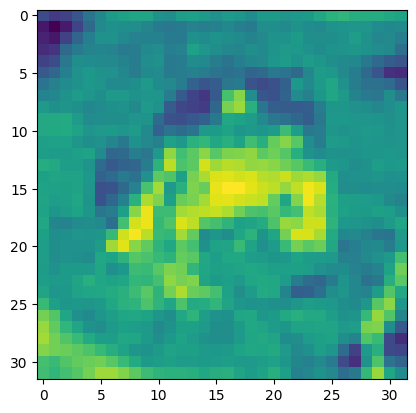

In [9]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0])

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [10]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [12]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    # self.act = nn.ReLU()
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x



이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [13]:
lr = 0.001

In [ ]:
from torch.optim import SGD

model_sgd = Model(32 * 32 * 3, 1024).to('cuda')
optimizer_sgd = SGD(model_sgd.parameters(), lr=lr)

- Adam Optimizer

In [ ]:
from torch.optim import Adam

model_adam = Model(32 * 32 * 3, 1024).to('cuda')
optimizer_adam = Adam(model_adam.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

- 테스트 데이터

In [14]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified


보조 함수


In [15]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [ ]:
sgd_accs = []
adam_accs = []

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss_sgd = 0.
  total_loss_adam = 0.

  # SGD 학습
  for data in trainloader:
    model_sgd.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_sgd(inputs)
    loss = torch.nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_sgd.step()

    total_loss_sgd += loss.item()

  sgd_accs.append(accuracy(model_sgd, trainloader))

  # Adam 학습
  for data in trainloader:
    model_adam.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_adam(inputs)
    loss = torch.nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_adam.step()

    total_loss_adam += loss.item()

  adam_accs.append(accuracy(model_adam, trainloader))
  print(f"Epoch {epoch:3d} | Loss(SGD): {total_loss_sgd} | Loss(Adam): {total_loss_adam}")

Epoch   0 | Loss(SGD): 450.5166554450989 | Loss(Adam): 433.22097182273865
Epoch   1 | Loss(SGD): 449.3428966999054 | Loss(Adam): 390.96919429302216
Epoch   2 | Loss(SGD): 448.3219792842865 | Loss(Adam): 367.9145978689194
Epoch   3 | Loss(SGD): 447.3608636856079 | Loss(Adam): 352.84621584415436
Epoch   4 | Loss(SGD): 446.44680643081665 | Loss(Adam): 341.129630446434
Epoch   5 | Loss(SGD): 445.5384712219238 | Loss(Adam): 332.737845659256
Epoch   6 | Loss(SGD): 444.5239088535309 | Loss(Adam): 324.55613601207733
Epoch   7 | Loss(SGD): 442.8902094364166 | Loss(Adam): 318.8113386631012
Epoch   8 | Loss(SGD): 441.3737187385559 | Loss(Adam): 312.0359665155411
Epoch   9 | Loss(SGD): 439.86141896247864 | Loss(Adam): 305.9622917175293
Epoch  10 | Loss(SGD): 438.36736726760864 | Loss(Adam): 300.43397438526154
Epoch  11 | Loss(SGD): 436.89315819740295 | Loss(Adam): 296.312642455101
Epoch  12 | Loss(SGD): 435.40212750434875 | Loss(Adam): 289.7235953807831
Epoch  13 | Loss(SGD): 433.69809913635254 | 

**Adam Optimizer**: momentum 덕분에 loss가 빠르게 줄어든다. (경사를 빠르게 내려감)

- Plot 1

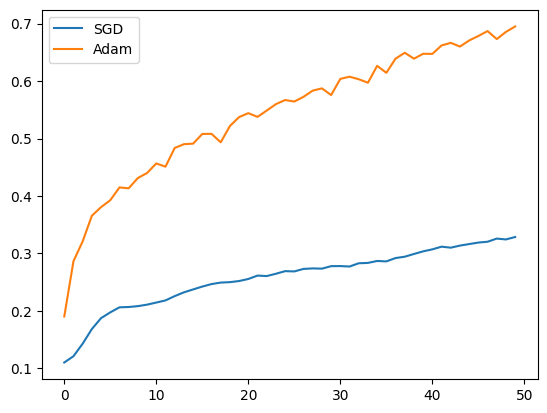

In [ ]:
plot_acc(sgd_accs, adam_accs,'SGD', 'Adam')

In [ ]:
from torch import nn


class SigmoidAppliedModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


In [ ]:
from torch.optim import Adam

model_leaky_relu = Model(32 * 32 * 3, 1024).to('cuda')
optimizer_leaky_relu = Adam(model_leaky_relu.parameters(), lr=lr)

model_sigmoid = SigmoidAppliedModel(32 * 32 * 3, 1024).to('cuda')
optimizer_sigmoid = Adam(model_sigmoid.parameters(), lr=lr)

In [ ]:
leaky_relu_accs = []
sigmoid_accs = []

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss_leaky_relu = 0.
  total_loss_sigmoid = 0.

  # Leaky ReLU 학습
  for data in trainloader:
    model_leaky_relu.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_leaky_relu(inputs)
    loss = torch.nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_leaky_relu.step()

    total_loss_leaky_relu += loss.item()

  leaky_relu_accs.append(accuracy(model_leaky_relu, trainloader))

  # Sigmoid 학습
  for data in trainloader:
    model_sigmoid.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_sigmoid(inputs)
    loss = torch.nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_sigmoid.step()

    total_loss_sigmoid += loss.item()

  sigmoid_accs.append(accuracy(model_sigmoid, trainloader))
  print(f"Epoch {epoch:3d} | Loss(Leaky ReLU): {total_loss_leaky_relu} | Loss(Sigmoid): {total_loss_sigmoid}")

Epoch   0 | Loss(Leaky ReLU): 426.92624056339264 | Loss(Sigmoid): 411.35438144207
Epoch   1 | Loss(Leaky ReLU): 388.99352622032166 | Loss(Sigmoid): 392.81903100013733
Epoch   2 | Loss(Leaky ReLU): 367.33411502838135 | Loss(Sigmoid): 387.3060268163681
Epoch   3 | Loss(Leaky ReLU): 351.21994960308075 | Loss(Sigmoid): 383.57854545116425
Epoch   4 | Loss(Leaky ReLU): 339.30586528778076 | Loss(Sigmoid): 381.27896666526794
Epoch   5 | Loss(Leaky ReLU): 329.37418270111084 | Loss(Sigmoid): 379.2812730073929
Epoch   6 | Loss(Leaky ReLU): 320.0384829044342 | Loss(Sigmoid): 377.80684089660645
Epoch   7 | Loss(Leaky ReLU): 312.6804563999176 | Loss(Sigmoid): 375.99050199985504
Epoch   8 | Loss(Leaky ReLU): 305.8554480075836 | Loss(Sigmoid): 374.4010329246521
Epoch   9 | Loss(Leaky ReLU): 300.8581665754318 | Loss(Sigmoid): 373.1988353729248
Epoch  10 | Loss(Leaky ReLU): 295.46444725990295 | Loss(Sigmoid): 371.84227085113525
Epoch  11 | Loss(Leaky ReLU): 288.8241184949875 | Loss(Sigmoid): 371.3368446

**Sigmoid**: Gradient Vanishing 때문인지, loss가 느리게 줄어든다.

- Plot 2

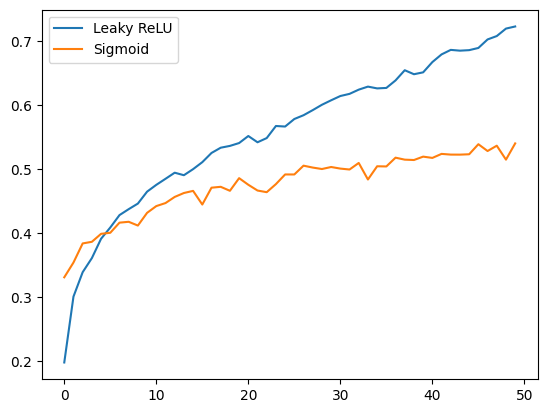

In [ ]:
plot_acc(leaky_relu_accs, sigmoid_accs,'Leaky ReLU', 'Sigmoid')

In [17]:
from torch import nn


class DroppedOutModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.dropout = nn.Dropout(0.1)
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x

In [18]:
from torch.optim import Adam

model_non_dropped_out = Model(32 * 32 * 3, 1024).to('cuda')
optimizer_non_dropped_out = Adam(model_non_dropped_out.parameters(), lr=lr)

model_dropped_out = DroppedOutModel(32 * 32 * 3, 1024).to('cuda')
optimizer_dropped_out = Adam(model_dropped_out.parameters(), lr=lr)

In [19]:
non_dropped_out_train_accs = []
non_dropped_out_test_accs = []
dropped_out_train_accs = []
dropped_out_test_accs = []

In [20]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss_non_dropped_out = 0.
  total_loss_dropped_out = 0.

  # Drop Out 미적용
  for data in trainloader:
    model_non_dropped_out.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_non_dropped_out(inputs)
    loss = torch.nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_non_dropped_out.step()

    total_loss_non_dropped_out += loss.item()

  non_dropped_out_train_accs.append(
      accuracy(model_non_dropped_out, trainloader))
  non_dropped_out_test_accs.append(
      accuracy(model_non_dropped_out, testloader))

  # Drop Out 적용
  model_dropped_out.train()
  for data in trainloader:
    model_dropped_out.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_dropped_out(inputs)
    loss = torch.nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_dropped_out.step()

    total_loss_dropped_out += loss.item()

  with torch.no_grad():
    model_dropped_out.eval()
    dropped_out_train_accs.append(
        accuracy(model_dropped_out, trainloader))
    dropped_out_test_accs.append(
        accuracy(model_dropped_out, testloader))

  print(f"Epoch {epoch:3d} | Loss(non dropped out): {total_loss_non_dropped_out} | Loss(dropped out): {total_loss_dropped_out}")

Epoch   0 | Loss(non dropped out): 433.0431203842163 | Loss(dropped out): 437.5108149051666
Epoch   1 | Loss(non dropped out): 397.6385387182236 | Loss(dropped out): 415.1635265350342
Epoch   2 | Loss(non dropped out): 373.5008542537689 | Loss(dropped out): 405.177507519722
Epoch   3 | Loss(non dropped out): 355.5677568912506 | Loss(dropped out): 395.1896963119507
Epoch   4 | Loss(non dropped out): 341.50872254371643 | Loss(dropped out): 387.891889333725
Epoch   5 | Loss(non dropped out): 331.3294680118561 | Loss(dropped out): 383.59517002105713
Epoch   6 | Loss(non dropped out): 323.7735493183136 | Loss(dropped out): 376.842067360878
Epoch   7 | Loss(non dropped out): 314.64888203144073 | Loss(dropped out): 372.09888768196106
Epoch   8 | Loss(non dropped out): 305.89388501644135 | Loss(dropped out): 368.9441442489624
Epoch   9 | Loss(non dropped out): 299.7739186286926 | Loss(dropped out): 365.66055059432983
Epoch  10 | Loss(non dropped out): 294.31258606910706 | Loss(dropped out): 36

- Plot 3

Non dropped out

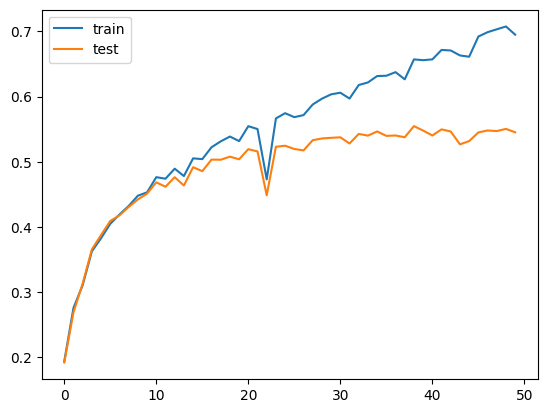

In [21]:
plot_acc(
  non_dropped_out_train_accs,
  non_dropped_out_test_accs)

Dropped out

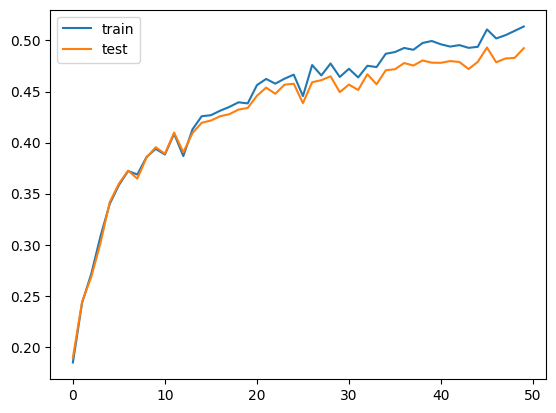

In [22]:
plot_acc(
  dropped_out_train_accs,
  dropped_out_test_accs)

- drop out 적용하지 않는 경우
  - train 데이터에 한해서, 정확도가 약 70% 까지 올랐지만,
  - 50 epoch 기준 test 데이터와 20% 정도 차이나므로 과적합이다.
- drop out 적용한 경우
  - neuron이 무작위로 비활성화 되어서인지, loss가 느리게 줄어든다. (학습이 느림)
  - test와 train의 차이가 많이 줄어들었다. (generalized)